In [1]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Initialize the wandb API
api = wandb.Api()

# Define the project and entity
entity = "L65_Project"
project = "transformer-graph-learner"

# Fetch all runs for the project
runs = api.runs(f"{entity}/{project}")
print("Fetching runs...")

# List to store filtered run data
data_points = []

for run in runs:
    # Filter for the specific group
    if run.group != "intermediate-supervision-16-nodes":
        continue

    config = run.config

    # Filter runs: model.intermediate_supervision must be False
    supervision = config.get('model', {}).get('intermediate_supervision', None)
    if supervision is None:
        continue

    # Ensure a seed exists (indicating different runs)
    seed = config.get('seed', None)
    if seed is None:
        continue

    # Get nhead (number of heads) from the model configuration
    nhead = config.get('model', {}).get('nhead', None)
    if nhead is None:
        continue

    # Fetch test_loss history
    test_loss_df = run.history(keys=["test_loss"])
    if "test_loss" not in test_loss_df.columns:
        continue

    # Calculate the minimum test loss for the run (across all epochs)
    best_test_loss = np.min(test_loss_df["test_loss"])

    # Get eccentricity from the dataset configuration (ensure it exists)
    eccentricity = config.get('dataset', {}).get('eccentricity', None)
    if eccentricity is None:
        continue

    # Get the number of layers for grouping within the graph
    num_layers = config.get('model', {}).get('num_layers', None)
    if num_layers is None:
        continue

    data_points.append({
        "eccentricity": eccentricity,
        "best_test_loss": best_test_loss,
        "num_layers": num_layers,
        "nhead": nhead,
        "seed": seed,
        "intermediate_supervision": supervision
    })

Fetching runs...


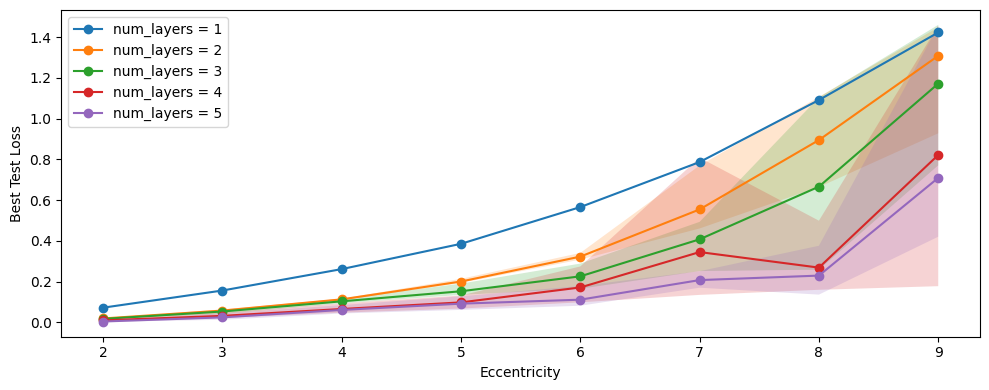

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Convert collected data to a pandas DataFrame
df = pd.DataFrame(data_points)

# Apply filters: intermediate_supervision == False, nhead == 1, and num_layers <= 4
df = df[
    (df["intermediate_supervision"] == False) &
    (df["nhead"] == 1)
    # (df["num_layers"] <= 4)
]

# Group the data by num_layers and eccentricity, calculating mean, min, and max of best_test_loss
grouped = df.groupby(["num_layers", "eccentricity"]).agg(
    mean_test_loss=("best_test_loss", "mean"),
    min_test_loss=("best_test_loss", "min"),
    max_test_loss=("best_test_loss", "max")
).reset_index()

# Plotting: for each unique num_layers, plot a line with error bars representing the min/max range
plt.figure(figsize=(10, 4))
unique_layers = grouped["num_layers"].unique()

for nl in unique_layers:
    # Filter data for the specific number of layers and sort by eccentricity for a smooth line
    data_nl = grouped[grouped["num_layers"] == nl].sort_values("eccentricity")
    x = data_nl["eccentricity"]
    y = data_nl["mean_test_loss"]

    y_min = data_nl["min_test_loss"]
    y_max = data_nl["max_test_loss"]
    plt.plot(x, y, marker='o', label=f'num_layers = {nl}')
    plt.fill_between(x, y_min, y_max, alpha=0.2)

    # # Calculate asymmetric error bars from min and max values
    # lower_error = y - data_nl["min_test_loss"]
    # upper_error = data_nl["max_test_loss"] - y
    # yerr = [lower_error, upper_error]
    #
    # plt.errorbar(x, y, yerr=yerr, marker='o', capsize=5, label=f'num_layers = {nl}')

# Draw a horizontal reference line (adjust the y value and label as needed)
# plt.axhline(y=0.04, color='r', linestyle='--', label='y=0.04')

plt.xlabel('Eccentricity')
plt.ylabel('Best Test Loss')
# plt.title('Test Loss vs Eccentricity (nhead=1, intermediate_supervision=False, num_layers<=4)')
plt.legend()
plt.tight_layout()

plt.savefig('mean_best_test_loss_vs_eccentricity_errorbar_16_nodes.pdf', dpi=150)
plt.show()


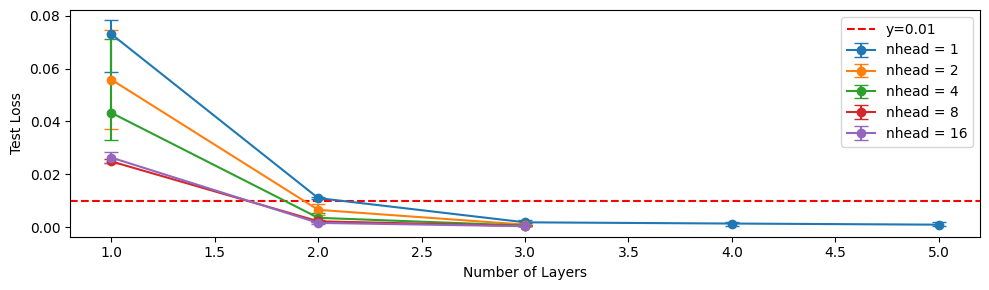

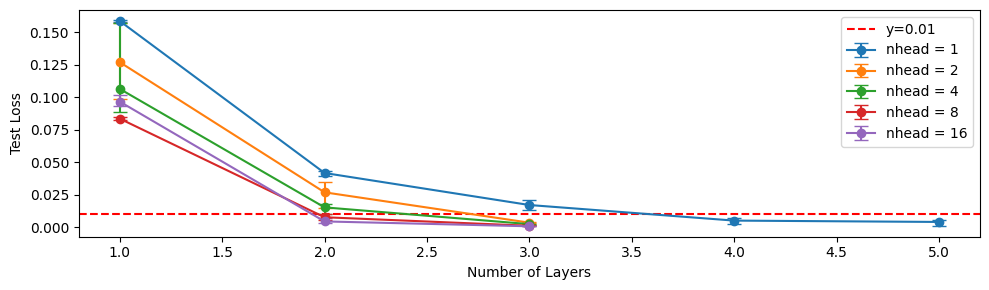

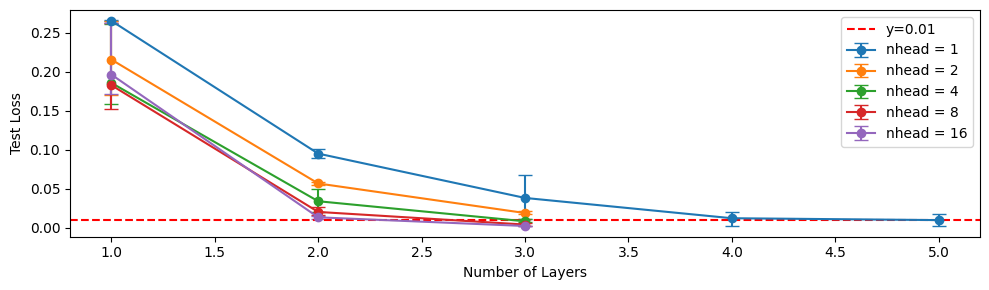

In [67]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
#
# # Assume data_points is already defined and contains your collected run data.
# df = pd.DataFrame(data_points)
#
# for ecc in [2,3,4]:
#     # Filter for runs with intermediate_supervision == False and eccentricity == 3
#     df_filtered = df[
#         (df["intermediate_supervision"] == False) &
#         (df["eccentricity"] == ecc)
#     ]
#
#     # Group by num_layers and nhead, calculating mean, min, and max of best_test_loss across seeds
#     grouped = df_filtered.groupby(["num_layers", "nhead"]).agg(
#         mean_test_loss=("best_test_loss", "mean"),
#         min_test_loss=("best_test_loss", "min"),
#         max_test_loss=("best_test_loss", "max")
#     ).reset_index()
#
#     plt.figure(figsize=(10, 3))
#     unique_nheads = grouped["nhead"].unique()
#
#     for nhead_val in unique_nheads:
#         # Filter and sort the data for this nhead value
#         data_nhead = grouped[grouped["nhead"] == nhead_val].sort_values("num_layers")
#         x = data_nhead["num_layers"]
#         y = data_nhead["mean_test_loss"]
#
#         # Calculate asymmetric error bars based on min and max values
#         lower_error = y - data_nhead["min_test_loss"]
#         upper_error = data_nhead["max_test_loss"] - y
#         yerr = [lower_error, upper_error]
#
#         plt.errorbar(x, y, yerr=yerr, marker='o', capsize=5, label=f'nhead = {nhead_val}')
#
#         # y_min = data_nhead["min_test_loss"]
#         # y_max = data_nhead["max_test_loss"]
#         # plt.plot(x, y, marker='o', label=f'nhead = {nhead_val}')
#         # plt.fill_between(x, y_min, y_max, alpha=0.2)
#
#     # Draw a horizontal reference line (adjust the y value and label as needed)
#     plt.axhline(y=0.01, color='r', linestyle='--', label='y=0.01')
#
#     plt.xlabel("Number of Layers")
#     plt.ylabel("Test Loss")
#     # plt.title(f"Test Loss vs Number of Layers (eccentricity={ecc}, intermediate_supervision=False)\nwith Min/Max Error Bars")
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig(f'mean_test_loss_vs_number_of_layers_errorbar_ecc_{ecc}.pdf', dpi=150)
#     plt.show()


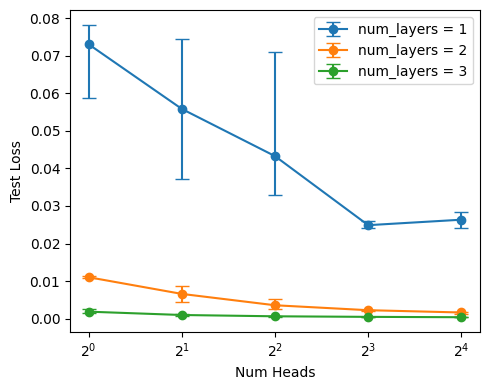

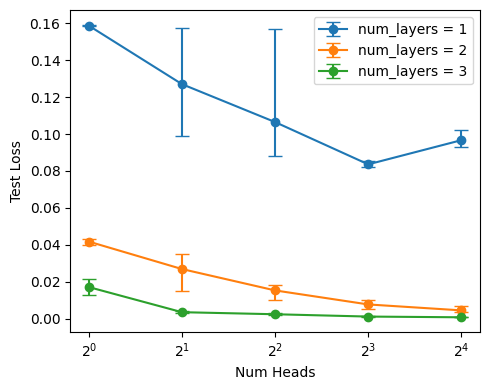

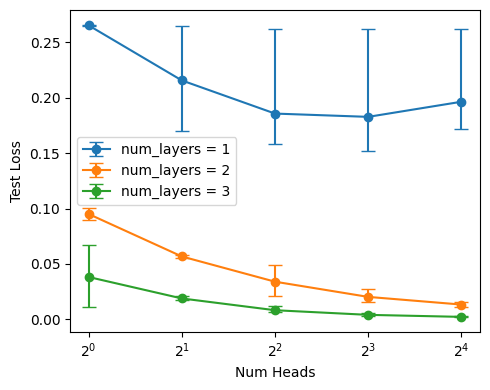

In [73]:
# Assume data_points is already defined and contains your collected run data.
df = pd.DataFrame(data_points)

for ecc in [2,3,4]:
    # Filter for runs with intermediate_supervision == False and eccentricity == 3
    df_filtered = df[
        (df["intermediate_supervision"] == False) &
        (df["eccentricity"] == ecc) &
    (df["num_layers"] <= 3)
    ]

    # Group by num_layers and nhead, and compute the mean, min, and max of best_test_loss.
    grouped = df_filtered.groupby(["num_layers", "nhead"]).agg(
        mean_test_loss=("best_test_loss", "mean"),
        min_test_loss=("best_test_loss", "min"),
        max_test_loss=("best_test_loss", "max")
    ).reset_index()

    plt.figure(figsize=(5, 4))

    # Get unique num_layers (each will be a separate line)
    unique_layers = grouped["num_layers"].unique()

    for layer in unique_layers:
        # Select and sort data for a given number of layers
        data_layer = grouped[grouped["num_layers"] == layer].sort_values("nhead")

        # Use log2(nhead) for the x-axis
        x = np.log2(data_layer["nhead"])
        y = data_layer["mean_test_loss"]

        # Calculate asymmetric error bars using the min and max values
        lower_error = y - data_layer["min_test_loss"]
        upper_error = data_layer["max_test_loss"] - y
        yerr = [lower_error, upper_error]

        plt.errorbar(x, y, yerr=yerr, marker='o', capsize=5, label=f'num_layers = {layer}')

    plt.xlabel("Num Heads")
    plt.ylabel("Test Loss")
    # plt.title("Test Loss vs log2(nhead) (eccentricity=3, intermediate_supervision=False, num_layers<=4)")
    plt.legend()

    # Set x-axis ticks to only show integer values.
    current_ticks = plt.xticks()[0]
    min_exp = int(np.floor(np.log2(df_filtered["nhead"].min())))
    max_exp = int(np.ceil(np.log2(df_filtered["nhead"].max())))
    xticks = np.arange(min_exp, max_exp + 1)

    # Use formatted labels like 2⁰, 2¹, ...
    xtick_labels = [f"$2^{{{i}}}$" for i in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.tight_layout()
    plt.savefig(f"mean_test_loss_vs_log2_nhead_ecc_{ecc}.pdf", dpi=150)

    plt.show()